# This project added great value in knowledge although the results were insignificant

## Predict potential profit in real-estate flips

The concept was that if a neural network could be trained to predict a price based on potential features available on DuProprio. Modifying values could give insight into the potential value of material choice and renovations that maximize profits. I assume people make fair assessments of the properties. An alternative approach could be to use gouvernment records about previous sales prices or following along further.

## Machine learning 
A artificial neural network and autoencoder were both experimented with. Such a problem may have been better approached with use of XGBOOST or a forest classifier.


## Data
The list of data per room from DuProprio was upacked and one-hot encoded. To avoid data which is too wide, I limit columns to more widely held, and therefore general categories. "County" is used because I am unclear as to what the proper term is although it is reference with "municipalities" on the centris statistics. Google geocoordinates were and various other processes are done directly on the database. 

I crafted features that felt relevant to an approach I would take in assessing valuable purchases. Through previous research, I felt that basic market statistics such as filtering by standard deviation from the mean and features designed on comparables within a distance were enough to see the posibilities available.

## Notes on input & output
I tried various modifications to the network architectures, at times trying to recreate the entire listing with the autoencoder and in others predicting from the listing input the ask price. No combination had extrodinary results especially when including one hot encoded features. 

## Challenges
-Processing the dataframe required me to journey into cython and try other options such as nimbus. Otherwise it was impossible. 

-My pipeline is very poor in design, I tried to avoid sklearn but perhaps some inhertance and exploration for the future is necessary 


## Bugs/Notes
There is a bug that forces the need for drop_duplicates(). 



In [1]:
import pymongo
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import json
import sklearn.preprocessing as pre
from sklearn.impute import SimpleImputer
from pandarallel import pandarallel


In [2]:
%load_ext Cython

In [3]:
%%cython

cimport numpy as np
# from collections cimport defaultdict
import pandas as pd

cpdef unpack_list(np.ndarray col):
    cdef int length = col.shape[0]
        
    cdef int i
    cdef int q
    
    ev = None
    for i in range(length):
        out = {}
        cell = col[i]
        if type(cell) == list:
            for q in range(len(cell)):
                out.update({cell[q]:1})
            if ev is None:
                ev = pd.Series(out)
            else:
                pd.concat([ev, pd.Series(out)])
    return ev

In [ ]:
%%cython

#WIP
cimport numpy as np
# from collections cimport defaultdict
import pandas as pd

cpdef unpack_list(np.ndarray col):
    cdef int length = col.shape[0]
        
    cdef int i
    cdef int q
    
    ev = None
    for i in range(length):
        out = {}
        cell = col[i]
        if type(cell) == list:
            for q in range(len(cell)):
                out.update({})
            if ev is None:
                ev = pd.Series(out)
            else:
                pd.concat([ev, pd.Series(out)])
    return ev

In [8]:
pandarallel.initialize()
class ProcessData:
    
    def __init__(self, cursor):
        frame = pd.DataFrame(cursor)
        # drop price upon request
        price = frame.loc[:, 'price']
        price = price.apply(lambda x: x if isinstance(x, int) else None)
        frame['price'] = price
        frame = frame[frame.price > 0]
        self.frame = frame
        self.scaler = None

        
    def feature_phase(self, frame=None):
        if frame is None:
            frame = self.frame
            
        frame = gpd.GeoDataFrame(frame, geometry=gpd.points_from_xy(frame['geo_index'].apply(lambda x: x['lng']),
                                                       frame['geo_index'].apply(lambda x: x['lat'])))

        def find_comparables(row):
            # compare within 6.78 km
            comparables = frame[frame.distance(row.geometry) < 0.03]

            if comparables.shape[0] > 3:
                comparables = comparables.dropna(subset=['Property taxes', 'School taxes'], axis=0)
                property_taxes = comparables['Property taxes'].apply(lambda x: x['monthly'] if not isinstance(x, float) else None)
                school_taxes = comparables['School taxes'].apply(lambda x: x['monthly'] if not isinstance(x, float) else None)
                total_tax = property_taxes + school_taxes
                # add mean comparison values
                row['compare_total_taxes_mean'] = round(total_tax.mean(), 2)
                row['compare_ask_mean'] = round(comparables.price.mean(), 2)
                row['compare_lot_mean'] = round(comparables['Lot dimensions'].mean(),2)
                row['compare_living_mean'] = round(comparables['Living space area (basement exclu)'].mean(), 2)
                # add median comparison values
                row['compare_total_taxes_med'] = round(total_tax.median(), 2)
                row['compare_ask_med'] = round(comparables.price.median(), 2)
                row['compare_lot_med'] = round(comparables['Lot dimensions'].median(),2)
                row['compare_living_med'] = round(comparables['Living space area (basement exclu)'].median(), 2)
                # add distance to most expensive house
                try:
                    row['distance_highest_price'] = row.geometry.distance(frame.iloc[comparables.price.idxmax()].geometry)
                except Exception as e:
                    print(e)
                    row['distance_highest_price'] = None
                
                # try to add correlation of values to price
            else:
                return row
            return row
        
        frame = frame.parallel_apply(find_comparables, axis=1)
        
        if frame is self.frame:
            self.frame = frame
        
        return frame
        
        
    def drop_phase(self, frame=None):
        if frame is None:
            frame = self.frame
            
        # drop by percent of missing values
        pct = 0.20
        missing_pct = frame.isnull().sum() > (frame.shape[0] * pct)
        frame = frame.loc[:, missing_pct == False]
        
        # drop if living space or lot dimensions are missing
        drop_cols = ['Living space area (basement exclu)', 'Lot dimensions']
        for col in drop_cols:
            frame = frame[frame[col] > 0]
            
        # drop columns that are not used to model
        drop_cols = ['_id', 'link', 'description', 'results', 'listing_num', 'address', 'geo_index']
        frame = frame.drop(columns=drop_cols)
        
        if frame is self.frame:
            self.frame = frame
            
        return frame
            
    
    def unpack_taxes(self, frame=None):
        if frame is None:
            frame = self.frame
        taxes = [x for x in frame if 'taxes' in x]
        for tax in taxes:
            frame[tax] = frame[tax].apply(lambda x: x['monthly'] if isinstance(x, dict) else None)
        
        if frame is self.frame:
            self.frame = frame        
        
        return frame
    
    def impute_missing(self, frame=None):
        if frame is None:
            frame = self.frame
            
        x = frame.select_dtypes(exclude=['object', 'geometry', '<M8[ns]'])
        scaler = pre.MinMaxScaler()
        a = scaler.fit_transform(x.apply(lambda i: i.fillna(frame[i.name].mean())))
        a = pd.DataFrame(a, columns=x.columns, index=x.index)
        frame = frame.select_dtypes(include=['object', 'geometry', '<M8[ns]']).join(a)
        a = None
        x = None
        
        if frame is self.frame:
            self.frame = frame
            self.scaler = scaler
        
        return frame, scaler
    
    def one_hot(self, frame=None):
        if frame is None:
            frame = self.frame
            
        # identify column names
        
        categ_frame = frame.select_dtypes(include=['object'])
        categ_cols = categ_frame.columns
        to_transform = categ_frame
        trans_cols = to_transform.columns
        # transform
        
        trans = to_transform.parallel_apply(lambda x: unpack_list(x.to_numpy()), axis=1)
#         to_transform.join(categ_frame[['last_modified', 'geo_index']])
        frame = frame.join(trans)
        frame = frame.drop(columns=categ_cols)
        frame = frame.fillna(0)
        frame = frame.drop_duplicates()
        
        if frame is self.frame:
            self.frame = frame
            
        return frame
    
    def centris_stats(self, frame=None, scaler=None):
        if frame is None and scaler is None:
            frame = self.frame
            scaler = self.scaler
            
        centris_stats = client['properties']['LiquidityPremium']
        market_stats = pd.DataFrame(list(centris_stats.find({})))
        market_stats = market_stats[['_id', 'name', 'Single-family', 'Population (2016)', 'Total residential']]
        market_sales_pct = market_stats['Single-family'].apply(lambda x: x['quarter']['sales']['percent'])
        market_sales_num = market_stats['Single-family'].apply(lambda x: x['quarter']['sales']['num'])
        market_selling_pct = market_stats['Single-family'].apply(lambda x: x['quarter']['avg_selling_time_days']['percent'])
        market_selling_num = market_stats['Single-family'].apply(lambda x: x['quarter']['avg_selling_time_days']['num'])


        stats_centris = pd.concat((market_sales_pct, market_sales_num, market_selling_pct, market_selling_num, market_stats.name), axis=1)

        stats_centris['county'] = stats_centris.apply(lambda x: x['name'].split(',')[0], axis=1)
        stats_centris['county'] = stats_centris.apply(lambda x: 'Ahuntsic / Cartierville' if 'Ahuntsic' in x['county'] else x['county'], axis=1)
        stats_centris['county'] = stats_centris.apply(lambda x: 'Venise-En-Quebec' if 'Venise' in x['county'] else x['county'], axis=1)
        stats_centris['county'] = stats_centris.apply(lambda x: 'Beauport' if 'Québec (Beauport)' in x['county'] else x['county'], axis=1)
        stats_centris['county'] = stats_centris.apply(lambda x: 'Stoneham' if 'Stoneham' in x['county'] else x['county'], axis=1)
        stats_centris['county'] = stats_centris.apply(lambda x: 'Cap-Rouge' if 'Cap-Rouge' in x['county'] else x['county'], axis=1)
        stats_centris['county'] = stats_centris.apply(lambda x: 'Charlesbourg' if 'Charlesbourg' in x['county'] else x['county'], axis=1)

        stats_centris['county'] = stats_centris.apply(lambda x: "-".join([x if x != 'Saint' else 'St' for x in x.county.split('-')  ]) if 'Saint' in x['county'] else x['county'], axis=1)
        stats_centris.columns = ['market_sales_pct', 'market_sales_num', 'market_selling_pct', 'market_selling_num', 'name', 'county']
        # Convert astericks to nan
        names = stats_centris[['name', 'county']]
        stats_centris = stats_centris.iloc[:, :-2].apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
        stats_centris = stats_centris.join(names)
        
        # scale the values
#         a = scaler.fit_transform(x)
#         a = pd.DataFrame(a, columns=x.columns, index=x.index)

        frame = (frame.reset_index()
                 .set_index('county')
                 .join(stats_centris
                 .set_index('county'))
                 .reset_index()
                 .set_index('index') )
        
        if frame is self.frame:
            self.frame = frame    
        
        return frame

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [9]:
client = pymongo.MongoClient('mongodb://localhost:27017/')
mdf = client['DuProprio']['ListingDetails']
cursor = mdf.find({'results': {'$exists': True}})
# df = pd.DataFrame(cursor)

In [10]:
test = ProcessData(cursor)

In [11]:
featured = test.feature_phase()

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


/Users/mathewzaharopoulos/Library/Python/3.7/lib/python/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [13]:
tax = test.unpack_taxes(featured)

In [15]:
centris = test.centris_stats(tax)

In [25]:
electricity = centris.apply(lambda x: x['Electricity']['monthly'] if str(x['Electricity']) != 'nan' else None, axis=1)

In [26]:
centris['Electricity'] = electricity

In [27]:
centris

,county,Basement,Bathroom,Bathrooms,Bedrooms,Carport,Certifications,Condo fees,Electricity,Equipment/Services Included,...,listing_num,lot_length,lot_width,price,results,market_sales_pct,market_sales_num,market_selling_pct,market_selling_num,name
index,,,,,,,,,,,,,,,,,,,,,
3473,Acton Vale,[Totally finished],"[Step-up bath, Ceramic Shower, Separate Shower]",2.0,NaN,NaN,NaN,NaN,166.67,"[Central vacuum, Shed, Cold room, Air exchange...",...,829958,NaN,NaN,479900.0,"[{'access_points': [], 'address_components': [...",137.0,19.0,0.0,0.0,"Acton Vale, Montérégie"
5125,Acton Vale,"[Partially finished, Concrete, Separate entrance]","[Whirlpool Bath Tub, Ceramic Shower, Separate ...",2.0,NaN,NaN,NaN,NaN,152.92,"[Central vacuum, Shed, Cold room, Fireplace, S...",...,797497,NaN,NaN,204000.0,"[{'access_points': [], 'address_components': [...",137.0,19.0,0.0,0.0,"Acton Vale, Montérégie"
5519,Acton Vale,"[Partially finished, Separate entrance]","[Step-up bath, Separate Shower]",1.0,NaN,[Detached],NaN,NaN,137.33,"[Central vacuum, Purification field, Central a...",...,872814,NaN,NaN,224900.0,"[{'access_points': [], 'address_components': [...",137.0,19.0,0.0,0.0,"Acton Vale, Montérégie"
7388,Acton Vale,"[Concrete, Unfinished]","[Step-up bath, Separate Shower]",2.0,NaN,NaN,NaN,NaN,NaN,"[Stove, Ceiling fixtures, Stove, A/C]",...,906074,NaN,NaN,133000.0,"[{'access_points': [], 'address_components': [...",137.0,19.0,0.0,0.0,"Acton Vale, Montérégie"
7734,Acton Vale,"[Partially finished, Concrete, Separate entrance]",[Bath and shower],2.0,NaN,NaN,NaN,NaN,80.25,"[Central vacuum, Shed, Cold room, Air exchange...",...,905969,NaN,NaN,210000.0,"[{'access_points': [], 'address_components': [...",137.0,19.0,0.0,0.0,"Acton Vale, Montérégie"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241,Yamachiche,"[Partially finished, Concrete]","[Bath and shower, Two sinks, Ceramic Shower]",2.0,NaN,NaN,NaN,NaN,158.33,"[Central vacuum, Shed, Cold room, Furnace, Fir...",...,901326,NaN,NaN,185000.0,"[{'access_points': [], 'address_components': [...",-34.0,4.0,0.0,0.0,"Yamachiche, Mauricie"
428,Yamaska,[Partially finished],[Bath and shower],1.0,NaN,[Attached],NaN,NaN,NaN,"[Shed, Furnace, Ceiling fixtures]",...,455834,NaN,NaN,174900.0,"[{'access_points': [], 'address_components': [...",0.0,2.0,0.0,0.0,"Yamaska, Montérégie"
1493,Yamaska,"[Totally finished, Concrete, Potential income]","[Bath and shower, Step-up bath, Ceramic Shower...",2.0,NaN,NaN,NaN,NaN,125.00,"[Laundry room, Shed, Cold room, Ceiling fixtur...",...,716503,NaN,NaN,252000.0,"[{'access_points': [], 'address_components': [...",0.0,2.0,0.0,0.0,"Yamaska, Montérégie"


In [137]:
abc.cov()['price'].sort_values(ascending=False)

price                                 0.006122
compare_ask_mean                      0.004914
compare_ask_med                       0.004633
Bathrooms                             0.002007
compare_living_med                    0.001964
School taxes                          0.001891
Half baths                            0.001629
Property taxes                        0.000146
compare_lot_mean                      0.000022
Lot dimensions                        0.000013
compare_lot_med                       0.000013
Living space area (basement exclu)    0.000013
compare_living_mean                   0.000012
Name: price, dtype: float64

In [28]:
dropped = test.drop_phase(centris)

In [34]:
def backyard_size(row):
    try:
        row['bkyard_size'] = row['Lot dimensions'] - row['Living space area (basement exclu)']
    except:
        row['bkyard_size'] = None
    return row

backyard = dropped.apply(backyard_size, axis=1)
    

In [38]:
numeric = backyard.select_dtypes(exclude=['object'])
categorical = backyard.select_dtypes(include=['object'])


,county,Basement,Bathroom,Equipment/Services Included,External facing,Floor coverings,Heating source,Kitchen,Location,Lot description,Near Commerce,Near Educational Services,Near Recreational Services,Parking / Driveway
index,,,,,,,,,,,,,,
3473,Acton Vale,[Totally finished],"[Step-up bath, Ceramic Shower, Separate Shower]","[Central vacuum, Shed, Cold room, Air exchange...","[Aluminium Siding, Fibre cement, Stone]","[Laminate, Hardwood, Ceramic]","[Convectair, Electric, Heat-pump]","[Raised panel maple, Wooden cabinets, Island, ...","[Near park, No backyard neighbors, Residential...","[Flat geography, Patio/deck, Landscaped]","[Supermarket, Drugstore, Financial institution...","[Daycare, Kindergarten, Elementary school, Hig...","[Golf course, Gym, Sports center, Library, ATV...","[Concrete, Double drive, Outside, With electri..."
5125,Acton Vale,"[Partially finished, Concrete, Separate entrance]","[Whirlpool Bath Tub, Ceramic Shower, Separate ...","[Central vacuum, Shed, Cold room, Fireplace, S...",[Brick],"[Hardwood, Ceramic, Parquet]","[Wood stove, Electric]","[Wooden cabinets, Island, Dishwasher, Stove, F...",[Residential area],"[Flat geography, Hedged, Patio/deck]","[Supermarket, Drugstore, Restaurant, Shopping ...",[Daycare],NaN,[Paving stone]
5519,Acton Vale,"[Partially finished, Separate entrance]","[Step-up bath, Separate Shower]","[Central vacuum, Purification field, Central a...","[Brick, Vinyl Siding]","[Laminate, Hardwood, Vinyl]","[Electric, Granulates]","[Melamine cabinets, Built-in oven, Island, Dis...",[No backyard neighbors],[Flat geography],"[Supermarket, Drugstore, Shopping Center]",NaN,"[Golf course, ATV trails]",[Asphalt]
7388,Acton Vale,"[Concrete, Unfinished]","[Step-up bath, Separate Shower]","[Stove, Ceiling fixtures, Stove, A/C]",[Massonite],[Laminate],"[Wood stove, Electric]","[Melamine wood imitation finish, Double sink]","[Near park, Residential area]",[Landscaped],"[Supermarket, Drugstore, Financial institution...","[Daycare, Kindergarten, Elementary school, Hig...","[Sports center, Library, Swimming pool]","[Asphalt, Double drive, Outside]"
7734,Acton Vale,"[Partially finished, Concrete, Separate entrance]",[Bath and shower],"[Central vacuum, Shed, Cold room, Air exchange...","[Aluminium Siding, Vinyl Siding, Stone]","[Hardwood, Ceramic, Vinyl]","[Wood stove, Convectair, Electric, Heat-pump, ...","[Melamine cabinets, Island, Stove, Fridge, Dou...","[Near park, Residential area]","[Flat geography, Corner lot, Patio/deck, Lands...","[Supermarket, Drugstore, Financial institution...","[Daycare, Kindergarten, Elementary school, Hig...","[Golf course, Gym, Sports center, Library, ATV...","[Asphalt, Double drive, Outside]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241,Yamachiche,"[Partially finished, Concrete]","[Bath and shower, Two sinks, Ceramic Shower]","[Central vacuum, Shed, Cold room, Furnace, Fir...","[Aluminium Siding, Wood, Brick, Stone]","[Concrete, Laminate, Hardwood, Linoleum, Carpe...","[Hot water, Electric, Propane gas, Dual-energy]","[Wooden cabinets, Dishwasher, Double sink]","[Highway access, Near park, No backyard neighb...","[Waterfront, Water view, Flat geography, River...","[Drugstore, Financial institution]","[Daycare, Elementary school]","[Library, Bicycle path, Pedestrian path]","[Asphalt, Double drive, Outside, With electric..."
428,Yamaska,[Partially finished],[Bath and shower],"[Shed, Furnace, Ceiling fixtures]","[Brick, Stone]","[Laminate, Hardwood, Ceramic]","[Forced air, Electric]","[Raised panel oak, Dishwasher, Double sink]",NaN,"[Water view, Corner lot, Patio/deck]","[Supermarket, Restaurant]",NaN,[ATV trails],[Asphalt]
1493,Yamaska,"[Totally finished, Concrete, Potential income]","[Bath and shower, Step-up bath, Ceramic Shower...","[Laundry room, Shed, Cold room, Ceiling fixtur...","[Brick, Stone]","[Laminate, Ceramic, Vinyl, Porcelain]","[Wood stove, Convectair, Electric, Baseboard]","[Melamine wood imitation finish, Dishwasher, S...","[Near park, 

In [123]:
def stringify(row):
    out = []
    for n, i in row.items():
        if type(i) == list:
            out.append(" ".join([n.lower()] + [b.lower() for b in i]))
    out = ". ".join(out)
#     out = np.array([i for i in out.split('. ')])
    return np.array(out)
            
t = categorical.apply(stringify, axis=1)

In [100]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [130]:
vocab_size=1000
embedding_dim = 50
max_length = 1200
trunc_type='post'
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(t)
word_index = tokenizer.word_index

In [132]:
training_sequences=tokenizer.texts_to_sequences(t)

In [134]:
training_padded=pad_sequences(training_sequences,maxlen=max_length,truncating=trunc_type)

In [256]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D, Embedding, Bidirectional, LSTM
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model, Model
from tensorflow.keras import regularizers
from keras.layers import concatenate


# x_train = x[:-50]
# y_train = y[:-50]
# x_test = x[-50:]
# y_test = y[-50:]


def model(x_size, y_size, vocab_size=vocab_size, embedding_dim=embedding_dim, input_length=max_length):
    
    
    inputA = Input((x_size,))
    inputB = Input((input_length,))
#     #word imbeddings
    
    embeddings = Embedding(vocab_size, embedding_dim, input_length=input_length)(inputB)
    nlp_out = Bidirectional(LSTM(128))(embeddings)
#     embedded = Flatten()(nlp_out)
    words = Model(inputs=inputB, outputs=nlp_out)
    
    t = Dense(x_size, activation="tanh", kernel_initializer='normal')(inputA)
    t = Dropout(0.5)(t)
    t = Dense(x_size//2, activation="tanh", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01))(t)
    t = Dropout(0.3)(t)
    t = Dense(512, activation="tanh", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01))(t)
    t = Dropout(0.1)(t)
    t = Dense(10, activation="tanh", kernel_initializer='normal')(t)
    t = Dense(y_size, activation='tanh')(t)
    num = Model(inputs=inputA, outputs=t)
    
    combined = concatenate([words.output, num.output])
    
    z = Dense(2, activation="relu")(combined)
    z = Dense(1, activation="linear")(z)
    
    model = Model(inputs=[words.input, num.input], outputs=z)

    met = tf.keras.metrics.MeanAbsolutePercentageError()
#     model.compile( 
#         loss='mean_absolute_error',
#         optimizer='adadelta',
#         metrics=[metrics.mae, met])
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
    return model

In [257]:
x = numeric.drop(columns=['price', 'geometry', 'last_modified'])
y = numeric.price

words = training_padded



# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None, verbose=0, copy=True, add_indicator=False)
# scaler = pre.MinMaxScaler()
# a = x.apply(lambda x: scaler.fit_transform(imp.fit_transform(x.to_numpy()))
# x = pd.DataFrame(a, columns= x.columns)
            
            
# imped = imp.fit_transform(x)
x_train = x[:-10]
y_train = y[:-10]
x_test = x[-10:]
y_test = y[-10:]
w_train = words[:-10]
w_test = words[-10:]

In [258]:
model = model(x_train.shape[1], 1, w_train.shape[0] )



In [252]:
w_train

index
3473    basement totally finished. bathroom step-up ba...
5125    basement partially finished concrete separate ...
5519    basement partially finished separate entrance....
7388    basement concrete unfinished. bathroom step-up...
7734    basement partially finished concrete separate ...
                              ...                        
2159    basement low (6 feet or under) unfinished. bat...
5889    basement partially finished separate entrance....
7415    basement totally finished. bathroom step-up ba...
291     basement totally finished separate entrance po...
1101    basement low (6 feet or under). equipment/serv...
Length: 8714, dtype: object

In [ ]:
batch_size=30
epochs=10
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    ModelCheckpoint('./temp/model.{epoch:02d}.hdf5', monitor='mean_absolute_error', save_best_only=True, verbose=0),
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='mean_absolute_error', patience=40, verbose=0),
    TensorBoard(log_dir='/Users/mathewzaharopoulos/dev/rebuild_realestate/temp/tues_model')
]

history = model.fit([w_train, x_train], y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_split = 0.10,
    callbacks=keras_callbacks)


# valid_score = model.evaluate(x_test, y_test, verbose=0)

In [745]:
test.frame.to_pickle('unpack_taxes_DuProprio.pkl')

In [21]:
abc, scaler = test.impute_missing(dropped)

In [27]:
def county_encode(row):
    row[str(row['county'])] = 1
    return row
county_info = ab.county.to_frame().parallel_apply(county_encode, axis=1)

AttributeError: 'GeoDataFrame' object has no attribute 'county'

# Pre one-hot encoding of list

In [30]:

county_info = county_info.fillna(0)
county_info

,Ahuntsic / Cartierville,Albanel,Alma,Amos,Amqui,Asbestos,Ascot Corner,Aumond,Auteuil,Baie-Comeau,...,St-Bernard-De-Lacolle,St-Jacques-Le-Mineur,St-Juste-Du-Lac,St-Malo,St-Marc-sur-Richelieu,St-Ours,St-Prosper-De-Dorchester,Ste-Anne-De-Bellevue,Val-Barrette,Verdun
index,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
# ab = test.one_hot(abc)
ab = test.one_hot(abc)


In [32]:
ab = ab.drop_duplicates()


In [79]:
#Drop columns
ab1 = ab.select_dtypes(exclude='object').rename_axis(index="").drop(columns=['geometry', 'last_modified', 'None']).drop_duplicates()

In [80]:
#join county info
ab1 = ab1.join(county_info.reset_index().drop_duplicates().rename_axis(index='')).drop(columns=['index'])

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
cors = ab1.corr()

In [239]:
test1 = dropped.set_index('county').join(county_info)

In [229]:
test1 = test1.dropna(axis=1)
# test1 = test1.drop(columns=['geometry', 'last_modified'])
cols, index = test1.columns, test1.index

test1.corr().style.background_gradient(cmap='viridis')

,Bathrooms,Half baths,Living space area (basement exclu),Lot dimensions,price
Bathrooms,1.000000,-0.059899,0.028245,0.003473,0.408366
Half baths,-0.059899,1.000000,0.013791,-0.013865,0.220972
Living space area (basement exclu),0.028245,0.013791,1.000000,0.002682,0.016956
Lot dimensions,0.003473,-0.013865,0.002682,1.000000,0.020372
price,0.408366,0.220972,0.016956,0.020372,1.000000


In [237]:
test1.cov().iloc[-1].to_frame().style.background_gradient(cmap='coolwarm')

,price
Bathrooms,61024.513417
Half baths,27804.800091
Living space area (basement exclu),152778864.892773
Lot dimensions,14434615723.410267
price,41633843813.814728


In [ ]:
test1.iloc[:,:-993]['distance_highest_price']

In [ ]:
sns.heatmap(data=abc.corr(), cmap='coolwarm',vmin=-1,vmax=1,center=0, annot=True)

In [81]:
for name, c in ab1.skew().sort_values().items(): print(f'{name:>10}, {c:>150}')

Totally finished,                                                                                                                                    -0.2591550232677469
    Verdun,                                                                                                                                                    0.0
St-Joseph-De-Sorel,                                                                                                                                                    0.0
St-Prosper,                                                                                                                                                    0.0
Trois-Rives,                                                                                                                                                    0.0
    Cabano,                                                                                                                                                    0.0
Ile d'O

In [82]:
import sklearn
ab2 = ab1.drop(columns=['county'])
cols, index = ab2.columns, ab2.index
ab2 = sklearn.preprocessing.power_transform(ab2, method='yeo-johnson', standardize=True, copy=True)


/Users/mathewzaharopoulos/Library/Python/3.7/lib/python/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [98]:
# for name, c in pd.DataFrame(ab2, columns=cols, index=index).skew().sort_values().items(): print(f'{name:>10}, {c:>150}')

In [153]:
ab3 = pd.DataFrame(ab2, columns=cols, index=index)
keep = [col for col, val in ab3.skew().items() if val <=1]

In [188]:
#try this guy
refined = ab3.loc[:,keep].dropna()
cor =refined.corr()
keep = [x for x, y in cor['price'].items() if str(y) != 'nan']
refined = refined.loc[:, keep]

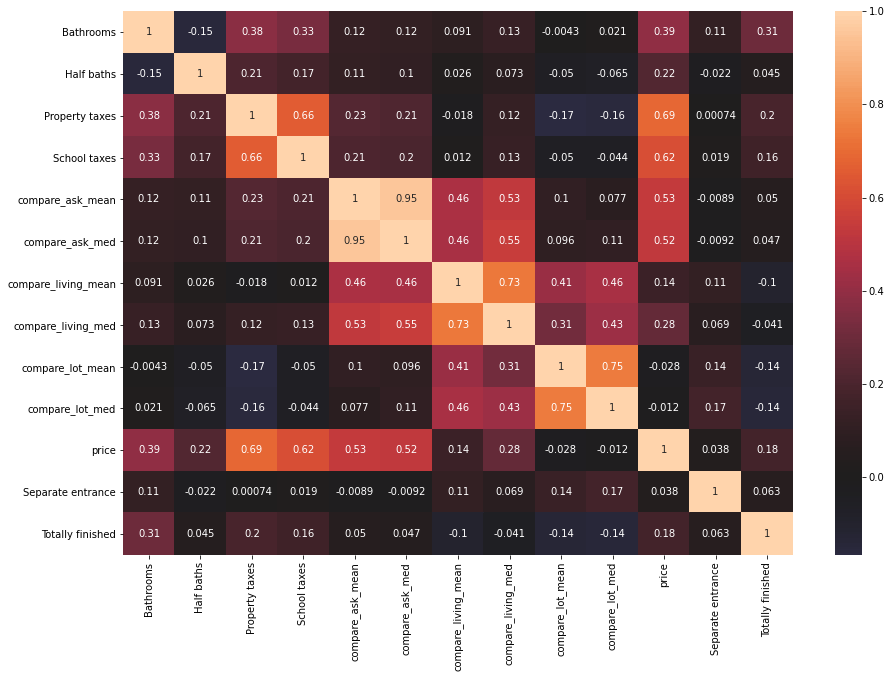

In [192]:
cor =refined.corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(data=cor,  annot=True, center=0)


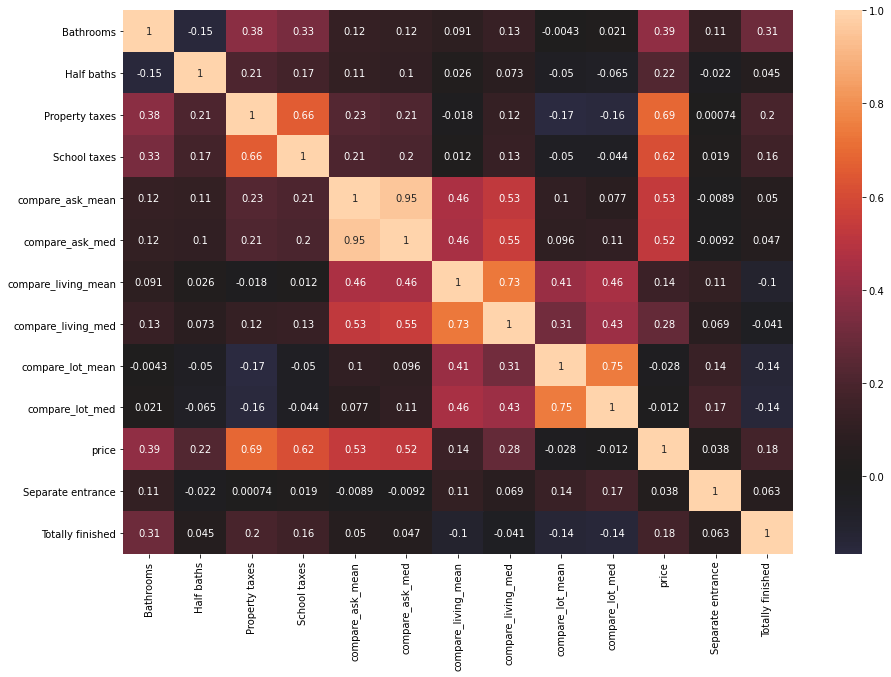

In [202]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(data=refined.cov(),  annot=True, center=0)

In [416]:
columns = ab1.iloc[:,-1097:]
col_index = []
for i in range(columns.shape[1]): 
    try:
        if columns.iloc[:,i].value_counts()[1] > 50: col_index.append(i)
    except:
        col_index.append(i)
        
column_names = columns.iloc[:, col_index].columns
drop_cols = [x for x in columns.columns if x not in column_names]

# ab1.iloc[:,-1097:]

In [421]:
aaaaa = aaaaa.dropna()

In [417]:
aaaaa = ab1.drop(columns=drop_cols)

In [357]:
for i in ab1.columns: print(i)

Bathrooms
Half baths
Living space area (basement exclu)
Lot dimensions
Property taxes
School taxes
compare_ask_mean
compare_ask_med
compare_living_mean
compare_living_med
compare_lot_mean
compare_lot_med
price
A/C
Air exchanger
Alarm system
B/I Microwave
Bath and shower
Blinds
Ceiling fixtures
Central air
Central vacuum
Ceramic Shower
Claw Foot Bathtub
Cold room
Concrete
Crawl basement
Crawl space
Dishwasher
Dryer
Fireplace
Freezer
Fridge
Furnace
Furnished
Low (6 feet or under)
No backyard neighbors
Partially finished
Potential income
Preserved wood foundation
Purification field
Residential area
Separate Shower
Separate entrance
Septic tank
Shed
Soaker bath
Step-up bath
Stone
Stove
Therapeutic bath
Thermo-masseur bath tub
Totally finished
Two sinks
Unfinished
Ventilator
Walk-in closet
Washer
Water softener
Well
Whirlpool Bath Tub
Window coverings
Bidet
Brick
California shutters
Carpet
Cedar wardrobe
Ceramic
Dehumidifier
Generator
Greenhouse
Half bath on the ground floor
Hardwood
Hot tu

In [383]:
aaaaa.dropna()

,Bathrooms,Half baths,Living space area (basement exclu),Lot dimensions,Property taxes,School taxes,compare_ask_mean,compare_ask_med,compare_living_mean,compare_living_med,...,St-Hermenegilde,St-Jean-De-Brebeuf,St-Joseph-De-Sorel,St-Leonard-De-Portneuf,St-Léonard-D'Aston,St-Luc-De-Vincennes,St-Mathieu-d'Harricana,St-Pamphile,St-Pierre-De-La-Riviere-Du-Sud,St-Prosper
,,,,,,,,,,,,,,,,,,,,,
2,0.250000,0.000000,0.000487,0.000619,0.007117,0.050017,0.295148,0.273347,0.000999,0.244341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.166667,0.000000,0.000487,0.000016,0.003566,0.066217,0.288810,0.264017,0.000447,0.172989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.166667,0.142857,0.000367,0.000047,0.003052,0.039522,0.256127,0.189210,0.000398,0.135320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.166667,0.142857,0.000853,0.000172,0.005226,0.066217,0.534931,0.385080,0.001142,0.564641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.083333,0.000000,0.000292,0.003276,0.005750,0.066217,0.295148,0.273347,0.000999,0.244341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8243,0.166667,0.142857,0.000527,0.000028,0.007545,0.051996,0.295148,0.273347,0.000999,0.244341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8322,0.166667,0.000000,0.000317,0.000020,0.006905,0.060228,0.295148,0.273347,0.000999,0.244341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8323,0.166667,0.142857,0.000372,0.000013,0.010503,0.130081,0.295148,0.273347,0.000999,0.244341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


scaler = pre.MinMaxScaler()
a = x.apply(lambda x: scaler.fit_transform(x.to_numpy())
x = pd.DataFrame(a, columns= x.columns)

In [194]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model, Model
from tensorflow.keras import regularizers



# x_train = x[:-50]
# y_train = y[:-50]
# x_test = x[-50:]
# y_test = y[-50:]

def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(x_size, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.5))
    t_model.add(Dense(x_size//2, activation="tanh", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.3))
    t_model.add(Dense(512, activation="tanh", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="tanh", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size, activation='tanh'))
    met = tf.keras.metrics.MeanAbsolutePercentageError()
    t_model.compile( 
        loss='mean_absolute_error',
        optimizer='adadelta',
        metrics=[metrics.mae, met])
    return t_model

def autoencoder(x_size, y_size):
    
    input_array = Input(shape=(x_size,))
    x = Dense(x_size, activation='relu')(input_array)
    x = Dense(x_size//2, activation='relu')(x)
    x = Dense(x_size//3, activation='relu')(x)
    
    x = Dense(x_size//4, activation='relu', kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01),activity_regularizer=regularizers.l1_l2(0.01), name='encoded')(x)

    y = Dense(20, activation='relu', name='code')(x)

    decoded = Dense(x_size//3, activation='relu')(y)
    decoded = Dense(x_size//2, activation='relu')(decoded)

    z = Dense(y_size, activation='relu', name='output')(decoded)
    model = Model(input_array, z)
#     opt = tf.keras.optimizers.Adam(lr=0.01)
    met = tf.keras.metrics.MeanAbsolutePercentageError()
    model.compile(
        loss='mean_absolute_error',
        optimizer='adadelta', #nadam
        metrics=[metrics.mae, met])
    return model

model = basic_model_3(x_train.shape[1], 1)
model2 = autoencoder(x_train.shape[1], 1)

In [97]:
x_train.shape[0]

7457

In [135]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 97)                9506      
_________________________________________________________________
dropout_9 (Dropout)          (None, 97)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 48)                4704      
_________________________________________________________________
dropout_10 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               25088     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)               

In [195]:
# %load_ext tensorboard
# %tensorboard --logdir '/Users/mathewzaharopoulos/dev/rebuild_realestate/temp/'
# !rm -rf '/Users/mathewzaharopoulos/dev/rebuild_realestate/temp/'
epochs = 1000
batch_size = 20
keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    ModelCheckpoint('./temp/model.{epoch:02d}.hdf5', monitor='mean_absolute_error', save_best_only=True, verbose=0),
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='mean_absolute_error', patience=40, verbose=0),
    TensorBoard(log_dir='/Users/mathewzaharopoulos/dev/rebuild_realestate/temp/linear6')
]

In [196]:


history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
    validation_split = 0.10,
    callbacks=keras_callbacks)


valid_score = model.evaluate(x_test, y_test, verbose=0)


In [197]:
scale1.inverse_transform(np.array(valid_score[1]).reshape(-1,1))

array([[1018598.45590591]])

In [120]:
scale1 = scaler
scale1.min_, scale1.scale_ = scale1.min_[-1], scale1.scale_[-1]

In [432]:
history2 = model2.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=0, # Change it to 2, if wished to observe execution
#     validation_split = 0.2,
    callbacks=keras_callbacks)

valid_score2 = model2.evaluate(x_test, y_test, verbose=0)

In [438]:
valid_score2
valid_score2 = model2.evaluate(x_test, y_test, verbose=0)
scale1.inverse_transform(np.array(valid_score2[1]).reshape(-1,1))

array([[128215.06140381]])

In [232]:
# error = model2.predict(x_test.join(y_test).iloc[1].to_frame().T)[-1][-1] - x_test.join(y_test).iloc[1].to_frame().T.price
# scale1.inverse_transform(error.to_numpy().reshape(-1,1))

In [439]:
data = x_test.join(y_test).iloc[1].to_frame().T
pd.DataFrame(scaler.inverse_transform(data), columns=data.columns)

,Bathrooms,Half baths,Living space area (basement exclu),Lot dimensions,Property taxes,School taxes,compare_ask_mean,compare_ask_med,compare_living_mean,compare_living_med,...,St-Jacques-Le-Mineur,St-Juste-Du-Lac,St-Malo,St-Marc-sur-Richelieu,St-Ours,St-Prosper-De-Dorchester,Ste-Anne-De-Bellevue,Val-Barrette,Verdun,price
0,261500.0,40000.0,40453.087628,40358.100999,47409.282702,95314.391952,824503.548391,766556.451436,42655.889294,689459.354134,...,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,40000.0,350000.0


In [662]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean', fill_value=None, verbose=0, copy=True, add_indicator=False)

imped = imp.fit_transform(x)
x_train = imped[:-10]
y_train = y[:-10]
x_test = imped[-10:]
y_test = y[-10:]

In [652]:
valid_score2 # 20% validation

[9512818708.48, 75238.6328125]

In [664]:
valid_score2 # mean

[10157221888.0, 70634.6640625]

In [659]:
valid_score2 # most frequent

[11036537856.0, 76819.625]

In [324]:
def centris():
    centris_stats = client['properties']['LiquidityPremium']
    market_stats = pd.DataFrame(list(centris_stats.find({})))
    market_stats = market_stats[['_id', 'name', 'Single-family', 'Population (2016)', 'Total residential']]
    market_sales_pct = market_stats['Single-family'].apply(lambda x: x['quarter']['sales']['percent'])
    market_sales_num = market_stats['Single-family'].apply(lambda x: x['quarter']['sales']['num'])
    market_selling_pct = market_stats['Single-family'].apply(lambda x: x['quarter']['avg_selling_time_days']['percent'])
    market_selling_num = market_stats['Single-family'].apply(lambda x: x['quarter']['avg_selling_time_days']['num'])

    
    stats_centris = pd.concat((market_sales_pct, market_sales_num, market_selling_pct, market_selling_num, market_stats.name), axis=1)

    stats_centris['county'] = stats_centris.apply(lambda x: x['name'].split(',')[0], axis=1)
    stats_centris['county'] = stats_centris.apply(lambda x: 'Ahuntsic / Cartierville' if 'Ahuntsic' in x['county'] else x['county'], axis=1)
    stats_centris['county'] = stats_centris.apply(lambda x: 'Venise-En-Quebec' if 'Venise' in x['county'] else x['county'], axis=1)
    stats_centris['county'] = stats_centris.apply(lambda x: 'Beauport' if 'Québec (Beauport)' in x['county'] else x['county'], axis=1)
    stats_centris['county'] = stats_centris.apply(lambda x: 'Stoneham' if 'Stoneham' in x['county'] else x['county'], axis=1)
    stats_centris['county'] = stats_centris.apply(lambda x: 'Cap-Rouge' if 'Cap-Rouge' in x['county'] else x['county'], axis=1)
    stats_centris['county'] = stats_centris.apply(lambda x: 'Charlesbourg' if 'Charlesbourg' in x['county'] else x['county'], axis=1)

    stats_centris['county'] = stats_centris.apply(lambda x: "-".join([x if x != 'Saint' else 'St' for x in x.county.split('-')  ]) if 'Saint' in x['county'] else x['county'], axis=1)
    stats_centris.columns = ['market_sales_pct', 'market_sales_num', 'market_selling_pct', 'market_selling_num', 'name', 'county']
        
    return stats_centris

In [325]:
cent = centris()

In [3]:
import xgboost